given as input two (circular) lists of 2-D Points each defining the boundary of a convex polygon, output a circular list of Points defining the boundary of the intersection (also a convex polygon)

in designing a practical algorithm we wish to be explicit about various special cases which may arise.
In a mathematical sense we could justifiably ignore these special cases, because they make up a set of measure zero. however it is counter-intuitive to use this fact to design software with a known built-in vulnerability. it would be embarassing to find the algorithm could not give a polygon back as its intersection with itself, for example, yet this would be an extremely unikely pairing to occur in random sampling.

in practice the special cases require us to define, identify, and devise an effective procedure for dealing with, various <em>singularities</em>. since testing real numbers against zero is not a precise operation, we shall work within a fuzzy-tolerance framework defined by the <a href =  "https://docs.python.org/3/library/math.html" > built-in function <b>math.isclose()</b>.</a>

the sort of problems we have to negotiate for special cases are illustrated by the following questions:

1. are two points the same?

2. does a point lie on a line?

3. are two line segments part of the same line?

we wish to get as precise an answer as possible within these constraints. efficiency is not a concern at this stage.

the first step is to introduce a dedicated class to polygons. the second is to implement a generic algorithm. once we are confident this is working ok, it should give guidance as to how to deal with more awkward cases.

In [70]:
import math
import random # just used for generating certain test data
ABS_TOL = 1.0e-8 # keep eyes on this parameter and how it is used!!

In [248]:
class ConvexPolygon:
    def __init__(self, list1, list2 = None):
        if list2 == None: # list1 is a list of Points
            self.P = list1
        else:            # separate input lists of X- and Y- coordinates
            self.X = list1
            self.Y = list2
            self.P = [Point(x,y) for (x,y) in zip(self.X, self.Y)]
            
        # insert check to remove redundancies in polygon boundary
        # reduce consecutive points which are within tolerance identical
        
        def test_same(A, B):
            return abs(A.x - B.x) + abs(A.y - B.y) < 2 * ABS_TOL


        def weed(alist):
            """from a list removes consecutive duplications identified by the function test_same()"""
            if len(alist) < 2: return alist
            j = len(alist) - 1
            while j > 0:
                a = alist[j]
                b = alist[j-1]
                if test_same(a,b):
                    alist.pop(j)
                j += -1
            return alist
        
        before = len(self.P)
        self.P = weed(self.P)
        after  = len(self.P)

            # remove consecutive arcs which determine (within tolerance) the same line 

        def aligned(X, Y, Z):
            return abs( X.line_to(Z).at(Y)) < ABS_TOL


        def simplify(P):
            """removes any redundant nodes """
            lenP = len(P)
            if lenP < 3 : return P
            j = 0
            check_aligned = []
            while j < lenP:
                X = P[(j-1) % lenP]
                Y = P[j]
                Z = P[(j+1) % lenP]
                check_aligned.append(aligned(X,Y,Z))
                j += 1
            j = lenP - 1
            while j >= 0:
                if check_aligned[j]:
                    P.pop(j)
                j += -1
            return P

        def area(P):
            s = 0
            for j in range(len(P)):
                k = (j +1) % len(P)
                s += (P[k].y + P[j].y) * (P[k].x - P[j].x)
            return  s  / 2

        self.P = simplify(self.P) 

        self.Area = area(self.P)
        if self.Area > 0:
            self.P = list(reversed(self.P)) # all Polygons described anticlockwise      
            self.Area = - self.Area
        
        # ensure the co-ordinate list is in synch with the possibly altered polygon
        self.X = [p.x for p in self.P]
        self.Y = [p.y for p in self.P]

        self.N = len(self.P)
        # make a dict containing the normalized equtions of the arcs
        self.arcs = dict(((self.P[j], self.P[(j+1) % self.N]), self.P[j].line_to(self.P[(j+1) % self.N])) 
                                     for j in range(self.N))

        
        self.pn = dict((self.P[j], j) for j in range(self.N)) # access point index
        
    def __str__(self): return str(self.P)
    
    def __repr__(self): return str(self)
    
    def classify(self, a1, a2 = None):
        """ given an input point (specified either way as a Point object or a pair (x, y))
        check which category it falls in (to the tolerance)
        
        0: coincides with a vertex 
        1: lies on an arc
        2: is an interior point
        3: is an exterior point
        
        output is returned as a list whose first item is a case_number
        and whose second item is a string-descriptor
        in cases 0 and 1 additional items identify the vertex or arc involved"""
        if a2 == None: # a1 is a Point
            x = a1.x
            y = a1.y
        else:
            x = a1
            y = a2
        
        # classify the point (x, y)
        
        
        def c(a, b): # alias to save typing
            return math.isclose(a, b, abs_tol = ABS_TOL)
        # 0
        for p in self.P:
            if c(x, p.x) and c(y, p.y): return [0, 'vertex', p]
        # 1        
        for (p, q) in self.arcs:
            if c(self.arcs[(p,q)].at(Point(x, y)), 0): 
                if  p.x < x < q.x or p.y < y < q.y:
                    return [1, 'on arc', p, q]
        # 2
        values = []
        for (p, q) in self.arcs: 
            values.append(self.arcs[(p, q)].at(Point(x,y)))
        if min(values) > 0 or max(values) < 0: return [2, 'interior point']
        
        # 3 (by default)
        return [3, 'exterior point']

In [249]:
#schema for testing Polygon.classify()
def point_near_0():
    x = 6 * ABS_TOL * (random.random() - 0.5)
    y = 6 * ABS_TOL * (random.random() - 0.5)
    return Point(x,y)

a = ConvexPolygon([1,1,1,0,0],[0,1,1,1,0])
for j in range(10):
    p = point_near_0()
    info = a.classify(p)
    print(p.scalarmu(1/ABS_TOL), info[1] )



( -1.82, -2.20) exterior point
(  0.72, -2.52) exterior point
(  0.27,  0.45) vertex
(  2.47,  1.17) interior point
( -2.72, -2.56) exterior point
(  1.98,  2.40) interior point
(  0.77, -1.73) exterior point
(  0.92, -2.20) exterior point
( -2.24,  1.83) exterior point
(  2.71, -1.98) exterior point


In [250]:
def intersection(P, Q):
    """ finds intersection of two convex polygons in the unproblematic case"""
    Pinfo = []
    for p in P.P:
        Pinfo.append(Q.classify(p))
    Qinfo = []
    for q in Q.P:
        Qinfo.append(P.classify(q))
    Pstats = dict((j, 0) for j in range(4))
    for gen in Pinfo:
        Pstats[gen[0]] += 1
    Qstats = dict((j, 0) for j in range(4))
    for gen in Qinfo:
        Qstats[gen[0]] += 1
    
    Psingularcases = Pstats[0] + Pstats[1]
    Qsingularcases = Qstats[0] + Qstats[1]
    
    if Pstats[3] == 0: return P # no points classed as exterior to  Q
    if Qstats[3] == 0: return Q # no points classed as exterior to  P
    
    if Psingularcases > 0 or Qsingularcases > 0:
        print("singular cases detected for which procedure is not in place")
        return []

    def check_intersection(A, B, C, D):
        """ returns True if AB meets CD at a point X 
        lying between A and B on AB
        and between C and D on CD"""
        L1 = A.line_to(B)
        L2 = C.line_to(D)
        return L1.at(C) * L1.at(D) < 0 and L2.at(A) * L2.at(B) < 0

    aux_dict = {}
    # set up auxiliary dictionary for information about intersections
    # between arcs of P and arcs of Q.
    # this information will then be collateded to extract the boundary
    for (a, b) in P.arcs:
        for(c, d) in Q.arcs:
            if check_intersection (a, b,  c, d):
                # if there is an unambiguous intersection, get the t-values on ab and on cd
                # needed if an arc has two intersections, which must be read in anti-clockwise order 
                tcd = P.arcs[(a, b)].intercept_t(c, d) # X = (1-tcd)*c + tcd*d
                tab = Q.arcs[(c, d)].intercept_t(a, b) # X = (1-tab)*a + tab*b
                # just while beta-testing calculate the intersection point in both possible ways
                Xcd = P.arcs[(a, b)].intercept(c, d)
                Xab = Q.arcs[(c, d)].intercept(a, b)
                # report any discrepancy
                if not ((abs(Xab.x - Xcd.x) + abs(Xab.y - Xcd.y)) < 2 * ABS_TOL):
                    print("discrepancy in check_intersection")
                # use the arithmetic mean
                X = Point(Xab.x + Xcd.x, Xab.y + Xcd.y)
                X = X.scalarmu(0.5)
                # and add the intersection point to the auxiliary dictionary
                
                if not a in aux_dict: # then start new list
                    aux_dict[a] = [(X, tab)]
                else: aux_dict[a].append((X, tab))
                
                if not c in aux_dict:
                    aux_dict[c] = [(X, tcd)]
                else: aux_dict[c].append((X, tcd))
    
    # now de-listify aux_dict and by sorting out correct linkage, make aux_dict into
    # a 1-1 derangement of a set consisting of a mixture of new intersection-generated nodes
    # and certain vertices of the original polygons. any orbit through this derangement will
    # give the required boundary
    
    INTERIOR = 2 # (the flag used to signify 'interior' in Pinfo and Qinfo field [0])
    
    # the dictionary entries were stored as lists (of length 1 or 2)
    # now we process it into the sequence representing the boundary of the required intersection
    # i.e. each intersection boundary point is a key, 
    # and the corresponding value is the next boundary point

    #  first polygon arcs 
    for (a, b) in P.arcs:
        if a in aux_dict: # if so, then the arc ab has one or two intersections with arcs of Q
            alist = aux_dict[a]
            if len(alist) == 1:
                # single entry implies ab is exterior to interior or vice versa
                # we use the dictionary P.pn to get the index no. of a in the Pinfo list
                if Pinfo[P.pn[a]][0] == INTERIOR: # a is interior to Q
                    aux_dict[a] = alist[0][0]
                else:               # b is interior to Q
                    aux_dict[a] = [] #flag a for removal
                    aux_dict[alist[0][0]] = b
            else:
                #double entry. first ensure t-values are respected
                if alist[1][1] < alist[0][1]: #t-values inverted
                    alist = list(reversed(alist))
                aux_dict[alist[0][0]] =  alist[1][0]
                aux_dict[a] = []
        else:
            # if a is an uncomplicated interior point of Q
            if Pinfo[P.pn[a]][0] == INTERIOR:
                aux_dict[a] = b # arc ab is interior to Q
            # if a is exterior to Q, then mark for removal
            else: aux_dict[a] = []

    # second polygon arcs
    for (c, d) in Q.arcs:
        if c in aux_dict:
            clist = aux_dict[c]
            if len(clist) == 1: 
                #single entry ext to int or vice versa
                if Qinfo[Q.pn[c]][0] == INTERIOR: # c is interior to P
                    aux_dict[c] = clist[0][0]
                else:                       # d is interior to P
                    aux_dict[c] = [] #flag for removal
                    aux_dict[clist[0][0]] = d
            else:
                #double entry. first ensure t-values are respected
                if clist[1][1] < clist[0][1]: #t-values inverted
                    clist = list(reversed(clist))
                aux_dict[c] = []
                aux_dict[clist[0][0]] =  clist[1][0]
        else:
            # if c is an uncomplicated interior point of 
            if Qinfo[Q.pn[c]][0] == INTERIOR:
                aux_dict[c] = d # arc cd is interior to P
            # if exterior, mark for removal
            else: aux_dict[c] = []
    
    aux_dict = dict((k, i) for (k, i) in aux_dict.items() if not i == [])            

    start = list(aux_dict.keys())
    outlist = []
    node = start[0]
    finished = False
    while not finished:
        outlist.append(node)
        node = aux_dict[node]
        finished = node == start[0]
    return ConvexPolygon(outlist)

In [251]:
import matplotlib
from matplotlib.pyplot import *
sq1 = ConvexPolygon([1,3,3,1],[1,1,3,3])

sq2 = ConvexPolygon([2,4,4,2],[2,2,4,4])
sq3 = intersection(sq1, sq2)
print(type(sq3))

<class '__main__.ConvexPolygon'>


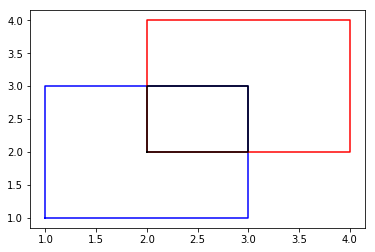

In [235]:
figure()
peedraw(plot, sq1.P, 'b', poly = True)
peedraw(plot, sq2.P, 'r', poly = True)
peedraw(plot, sq3.P, 'k', poly = True)
show()

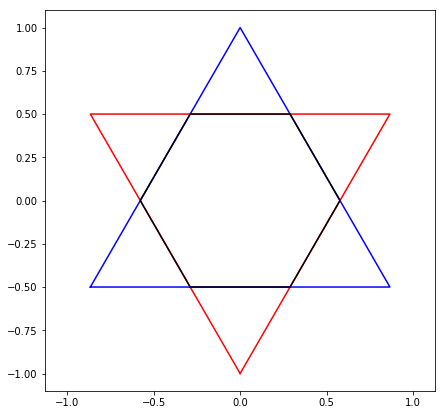

In [252]:
X = [-0.866, 0.866, 0]
uY = [-0.5, -0.5, 1 ]
lY = [0.5, 0.5, -1]
T1 = ConvexPolygon(X, uY)
T2 = ConvexPolygon(X, lY)
#print(T1.P)
#print(T2.P)
T3 = intersection(T1, T2)
figurehead(7)
peedraw(plot, T1.P, 'b', poly = True)
peedraw(plot, T2.P, 'r', poly = True)
peedraw(plot, T3.P, 'k', poly = True)
show()



In [212]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        
    def __str__(self):
        return "({0:6.2f},{1:6.2f})".format(self.x, self.y) 
    
    def __repr__(self):
        return str(self)
    
    def line_to(self, q):
        return Line(self.y - q.y, -self.x + q.x, self.x* q.y - self.y * q.x)   
       
    def plus(self, q):
        return Point(self.x + q.x, self.y + q.y)
    
    def minus(self, q):
        return Point(self.x - q.x, self.y - q.y)

    def scalarmu(self, mu):
        x = mu * self.x
        y = mu * self.y
        return Point(x,y)
    
    def scalarprod(self, q):
        return self.x * q.x + self.y * q.y
    
    def reflect(self, p, q):
        t = self.minus(q).scalarprod(p.minus(q)) / p.minus(q).scalarprod(p.minus(q))
        M = q.scalarmu(1-t).plus(p.scalarmu(t))
        return M.scalarmu(2).minus(self)

    def half_reflect(self, p, q):
        t = self.minus(q).scalarprod(p.minus(q)) / p.minus(q).scalarprod(p.minus(q))
        M = q.scalarmu(1-t).plus(p.scalarmu(t))
        return M
    
    #######################################################################################
    def is_inside(self, P):
        # the problem of intersection requires attention. 
        vals = [P[n].line_to(P[(n + 1) % len(P)]).at(self) for n in range(len(P))]
        mi = min(vals)
        ma = max(vals)
        return  (mi > 0 or math.isclose(mi, 0)) or (ma < 0 or math.isclose(ma, 0))
    ######################################################################################
    
    def perpbis(self, q): # get equation of perpendicular bisector of self and q
        dx = self.x - q.x
        dy = self.y - q.y
        a = (dx * dx + dy * dy) / 2 + q.x * dx + q.y * dy
        return Line(dx, dy, -a)
    
    def Pshrink_to(self, Plist, scale = 1):
        # scaling transform on Plist using self as origin
        def Pshrinkto(P, Q, sc):
            Px = Q.x - (Q.x - P.x ) * sc
            Py = Q.y - (Q.y - P.y ) * sc
            return Point(Px, Py)
        outlist = []
        Q = self
        for P in Plist:
            outlist.append(Pshrink(P, Q, scale))
        return outlist
    
    def distance_from(self, q):
        dx = self.x - q.x
        dy = self.y - q.y
        return math.sqrt(dx * dx + dy * dy)
                
            


Pinf = Point(10000,10000)

class Line():
    def __init__(self, a, b, c):
        # normalize
        root = math.sqrt(a * a + b * b)
        self.a = a / root
        self.b = b / root
        self.c = c / root

    def __str__(self):
        return "({0:6.4f},{1:6.4f},{2:6.4f})".format(self.a, self.b, self.c)    
    
    def __repr__(self):
        return str(self)
 
        
    def same_side(self, p, q):
        return self.at(p) * self.at(q) >= 0
    
    def polygon_clip(self, poly): # returns a list of intersection points of self with poly
        n = len(poly)
        clip = []
        for p in range(n):
            q = (p + 1) % n
            if not self.same_side(poly[p], poly[q]):
                r = self.intercept(poly[p], poly[q])
                if not r == Pinf:
                    clip.append(r)
        return clip
   
    def polygon_update(self, poly): # should only be called if we are sure that
                                    # there are two intersection points (call polygon_clip first)
        n = len(poly)
        poly2 = []
        poly2.append([])
        poly2.append([])
        current = 0
        for p in range(n):
            poly2[current].append(poly[p])
            q = (p + 1) % n
            if not self.same_side(poly[p], poly[q]):
                r = self.intercept(poly[p], poly[q])
                poly2[current].append(r)
                current = (current + 1) % 2
                poly2[current].append(r)
       
        return poly2 # NB poly2 returns a LIST containing two polygons
    
    # evaluate linear function at p
    def at(self, p):
        return self.a * p.x + self.b * p.y + self.c
    
  
    def intercept(self, p, q):
        """ returns the point of intersection of self with the line joining p and q"""
        s = (self.a * (p.x - q.x) + self.b * (p.y - q.y)) # determinant
        if  math.isclose(s, 0):
            return Pinf # point at infinity. not really implemented as yet!
        else:
            t = (self.a * p.x + self.b * p.y + self.c)/s
            return p.scalarmu(1-t).plus(q.scalarmu(t))
    
    def intercept_t(self, p, q):
        """ returns the point of intersection of self with the line joining p and q
        as a real number t such that the point is (1-t)P +tQ"""
        s = (self.a * (p.x - q.x) + self.b * (p.y - q.y)) # determinant
        if  math.isclose(s, 0):
            return INF # infinity. not really implemented as yet!
        else:
            t = (self.a * p.x + self.b * p.y + self.c)/s
            return t

    def meets(self, L):
        a1, b1, c1 = self.a, self.b, self.c
        a2, b2, c2 = L.a, L.b, L.c
        det = a1 * b2 - a2 * b1
        if math.isclose(det,0):
            print('Pinf in meets()')
            return Pinf
        xfac = c1 * b2 - c2 * b1
        yfac = a1 * c2 - a2 * c1
        return Point( -xfac / det, -yfac / det)
   
INF = 10000
        

In [116]:
def next_point(P, q, Q):
    """the engine of the 'network1 algorithm"""
    L = q.perpbis(Q) # get equation of perpendicular bisector of q and Q
    clip = L.polygon_clip(P) # list of intersection points of line L and polygon P
    if len(clip) == 2: # rule out any exceptional cases. this requires looking at later +++++++ NB +++++++++++
        poly2 = L.polygon_update(P)
        #polygon_update returns two lists, with the newly computed intersection points added to each.
        
        # to determine which of the twob polgygons q is in we use signed distances from L
        a0 = L.sum_of_distance(poly2[0])
        a1 = L.sum_of_distance(poly2[1])
        a = L.at(q) # value of ax + by +c for  q = (x, y)
        
        if a * a0 > 0 and poly2[0]: # a and a0 have same sign
            return poly2[0]
        else:
            return poly2[1]
    else:
        return P


def network1(poly, seedlist):
    """ returns a dictionary indexed by the seed points of polygons (as lists of points) 
    subdividing poly ( for poly = external boundary, only rectangles have been considered so far) 
    each output polygon defines the base region round one of the points of seedlist"""
    
    Q = list(seedlist)
    cell_dict = {} # polygon coordinates
    for q in Q:
        # reset the initial polygon
        P = list(poly)
        for nextq in Q:
            if not nextq == q:
                P = next_point(P, q, nextq)
        cell_dict[q] = P
    return cell_dict

#-------------------------------------------------------------------------------------
#

def next_vertex(P, j):
    return P[(j+1) % len(P)]

def poly_overlap(P, Q):
    def check_intersection(A, B, C, D):
        L1 = A.line_to(B)
        L2 = C.line_to(D)
        return L1.at(C) * L1.at(D) <= 0 and L2.at(A) * L2.at(B) <= 0
    score = False
    j = 0
    while not score and j < len(P):
        p = P[j]
        q = next_vertex(P, j)
        j += 1
        k = 0
        while not score and k < len(Q):
            r = Q[k]
            s = next_vertex(Q, k)
            k += 1
            score = check_intersection(p, q, r, s)
    return score



In [117]:
# check area function gives correct signs
sqx = [1,2,2,1]
sqy = [2,2,1,1]
SQ1  = [Point(sqx[j],sqy[j]) for j in range(4)]
SQ2   = []
for k in range(4):
    SQ2.append(Point(-SQ1[k].x, SQ1[k].y))

print("area SQ1 = {:6.4f}".format(area(SQ1)))
print("area SQ2 = {:6.4f}".format(area(SQ2)))
SQ2r = list(reversed(SQ2))
print("area SQ2 reversed = {:6.4f}".format(area(SQ2)))


area SQ1 = 1.0000
area SQ2 = -1.0000
area SQ2 reversed = -1.0000


In [118]:
 
def area(P):
    """returns the (signed) area of the polygon P (list of Points)
    polygons described clockwise yield positive values for their area"""
    s = 0
    for j in range(len(P)):
        k = (j +1) % len(P)
        s += (P[k].y + P[j].y) * (P[k].x - P[j].x)
    return  s  / 2

def turn(P, Q, R):
    """answers the question: moving from P towards Q, is from Q towards R a left turn, 
    straight on or a right turn?
    convex polygons described anticlockwise yield non-negative values for turn at each vertex"""
    return P.line_to(Q).at(R)

def is_convex(P):
    turnlist = []
    lenP = len(P)
    if lenP  < 4: return True #trivial cases
    for j in range(lenP):
        p1 = P[j]
        p2 = P[ (j+1) % lenP]
        p3 = P[ (j+2) % lenP]
        turnlist.append(turn(p1, p2, p3))
        print(turn(p1, p2, p3))
    mi = min(turnlist)
    ma = max(turnlist)
    return  (mi > 0 or math.isclose(mi, 0)) or (ma < 0 or math.isclose(ma, 0))
        
is_convex(SQ2)

1.0
1.0
1.0
1.0


True

In [176]:
def figurehead(f):
    #standard bit of graphics  plot initialization.  call this function to save typing
    figure(figsize=(f,f))
    axes().set_aspect('equal','datalim')


def polyplot(poly,*args,**kwargs):
    # now superseded by the poly kwarg in peedraw
    poly.append(poly[0])
    peedraw(plot, poly, *args, **kwargs)
    poly.pop()


def peedraw(func, pointlist, *args, poly = False, **kwargs): 
    """plots/fills/scatters a list of Points 
     (whereas the pyplot plot function takes a list of x and a list of y co-ords)
    func is the function name
    pointlist is the  list of Points 
    poly (default False) should be set to true when the closing arc is needed (plot only)
    NB differences in var lists, particularly scatter *args
   """
    x = []
    y = []
    for p in pointlist:
        x.append(p.x)
        y.append(p.y)
    if not poly:        
        func(x,y,*args,**kwargs)
    else:
        x.append(x[0])
        y.append(y[0])
        func(x, y, *args, **kwargs)

def circle(a, b, r, npoints = 500):
    """returns a listof points forming a regular polygon with npoints sides, center (a,b), radius r"""
    C = []
    
    for n in range(npoints):
        theta =  math.pi / 2 + 2 * math.pi * n / npoints
        C.append(Point(a + r * math.cos(theta), b + r * math.sin(theta)))
                     
    return C




In [119]:
errmsg = {0: "error in interception() - ",
          1: "an input polygon has less than three vertices",
          2: "an input polygon is not convex",
          3: "an input polygon has zero area"}

def check_intersection(A, B, C, D):
    L1 = A.line_to(B)
    L2 = C.line_to(D)
    return L1.at(C) * L1.at(D) <= 0 and L2.at(A) * L2.at(B) <= 0
 
def err(n = 0):
    print(errmsg[0] + errmsg[n])
    # stop or enter debug mode

def polygon_intersection(Pinput, Qinput):
    P, Q = list(Pinput), list(Qinput) # local copies
    np = len(P)
    nq = len(Q)
    # check validity of inputs

    if np < 3 or nq < 3: err(1)
    if not (is_convex(P) and is_convex(P)): err(2)
    aP, aQ = area(P), area(Q)
    if math.isclose(aP,0) or math.isclose(aQ, 0): err(3)
    if aP * aQ < 0:
        # ensure both polygons are described anticlockwise
        if area(P) > 0: P = list(reversed(P))
        if area(Q) > 0: Q = list(reversed(Q))

    # check if one polygon is entirely contained within the other
    # this should (incidentally) correctly handle the exceptional case with P = Q
    QinP = filter(lambda point: point.is_inside(P), Q)
    if len(QinP) == nq: return Q # Q is inside P
    PinQ = filter(lambda point: point.is_inside(Q), P)
    if len(PinQ) == np: return P # P is inside Q

    # choose a starting point
    PoutsideQ = list(set(P) - set(PinQ))
    start_j = P.index(PoutsideQ[0])
    outlist = []
    this_j = start_j
    while  number_of_intersections(this_j, P[(this_j + 1) % np], Q) == 0:
        this_j = (this_j + 1) % np
    


In [34]:
print(math.inf)

inf
